In [1]:
!pip install pymongo
!pip install seaborn
!pip install matplotlib
!pip install nltk
!pip install WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.1/672.1 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.0/785.0 kB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 2.2 MB/s eta 0:00:0000:0100:01m


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,regexp_replace,explode,split
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
from wordcloud import WordCloud

In [3]:
from pymongo import MongoClient

username = "root"  
password = "root"  
host = "192.168.214.1"
port = 27018
authSource  = "admin"  # default is admin

# Connect to MongoDB
client = MongoClient(
                      host
                     ,port
                     ,username = username
                     ,password = password
                     ,authSource  = authSource 
                    )  # assuming your MongoDB container is named 'mongodb'

# Get the database
db = client['wikimedia']
print("wikimedia db 建立完成!")

# Get the collection
collection = db['wikimedia_collection']
print("wikimedia collection 建立完成!")

wikimedia db 建立完成!
wikimedia collection 建立完成!


In [4]:
# Get MongoDB wikimedia_collection documents total counts
document_count = collection.count_documents({})
print(f'Total number of documents: {document_count}')

Total number of documents: 19428


In [5]:
# Assign headers
fields = {
    'type': 1,
    'title': 1,
    'title_url': 1,
    'comment': 1,
    'timestamp': 1,
    'user': 1,
    'bot': 1,
    '_id': 0  # not include _id
}

# Get collection toatl datas
documents = list(collection.find({}, fields))

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MongoDB to Spark DataFrame") \
    .getOrCreate()

#  MongoDB documents to Spark DataFrame
df = spark.createDataFrame(documents)

# Order by assigned headers
desired_order = ['type', 'title', 'title_url', 'comment', 'timestamp', 'user', 'bot']
df = df.select(*desired_order)

# Print DataFrame schema
df.printSchema()

# Show DataFrame comment
df.show()

root
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- title_url: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user: string (nullable = true)
 |-- bot: boolean (nullable = true)

+----------+--------------------+--------------------+--------------------+----------+--------------------+-----+
|      type|               title|           title_url|             comment| timestamp|                user|  bot|
+----------+--------------------+--------------------+--------------------+----------+--------------------+-----+
|      edit|File:SDO 20240525...|https://commons.w...|/* wbeditentity-u...|1716614194|     OptimusPrimeBot| true|
|categorize|Category:Taken on...|https://commons.w...|[[:File:SDO 20240...|1716614192|     OptimusPrimeBot| true|
|      edit|          Q126093098|https://www.wikid...|/* wbsetreference...|1716614194|           Emijrpbot| true|
|      edit|           Q90056882|https://www.w

+----------+-----+
|      type|count|
+----------+-----+
|       new|  408|
|       log|  600|
|      edit|13201|
|categorize| 5219|
+----------+-----+



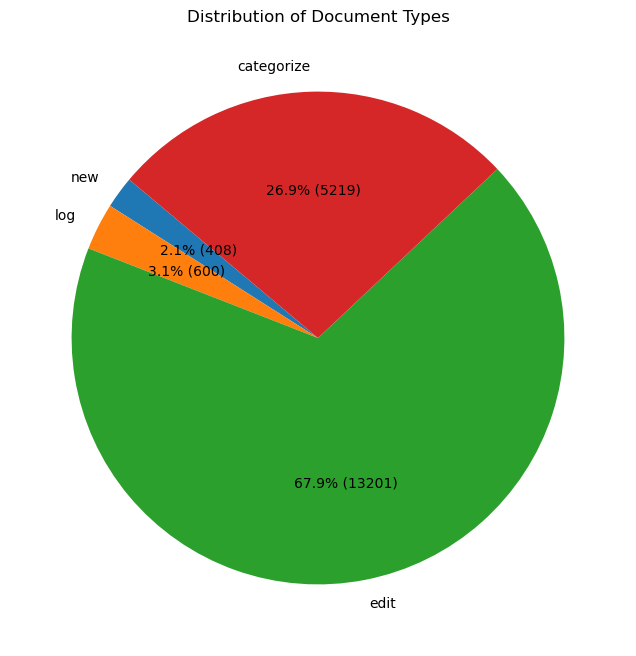

In [6]:
# According type to draw Percentage pie chart

# According `type` to group count
type_counts = df.groupBy("type").count()

# Show `type` count
type_counts.show()

# To Pandas DataFrame
type_counts_pd = type_counts.toPandas()

# Customize autopct to display both the percentage and the count
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}% ({val:d})'
    return my_format

# Create a pie chart using Seaborn and Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(type_counts_pd['count'], labels=type_counts_pd['type'], autopct=autopct_format(type_counts_pd['count']), startangle=140)
plt.title('Distribution of Document Types')
plt.show()

In [7]:
# Calculate the number of different users
distinct_users = df.select("user").distinct().count()
print(distinct_users)

1423


In [8]:
# Calculate the total count of distinct users, and sort them in descending order by count
distinct_users_sorted = df.groupBy("user").count().orderBy(col("count").desc())
distinct_users_sorted.show()

+--------------------+-----+
|                user|count|
+--------------------+-----+
|           Emijrpbot| 1496|
|        Research Bot| 1384|
|         Dcirovicbot| 1026|
|           Balyozbot| 1013|
|           DaxServer|  993|
|               Bob08|  884|
|              Cewbot|  547|
|               Sic19|  538|
|       Twofivesixbot|  502|
|       Reinhardhauke|  478|
|              QICbot|  376|
|         Wicci'o'Bot|  369|
|u0531u0577u0562u0...|  336|
|Ser Amantio di Ni...|  271|
|             Auntof6|  236|
|               Z3lvs|  222|
|     OptimusPrimeBot|  221|
|       El Nuevo Doge|  205|
|          LucasBrown|  183|
|               KrBot|  183|
+--------------------+-----+
only showing top 20 rows



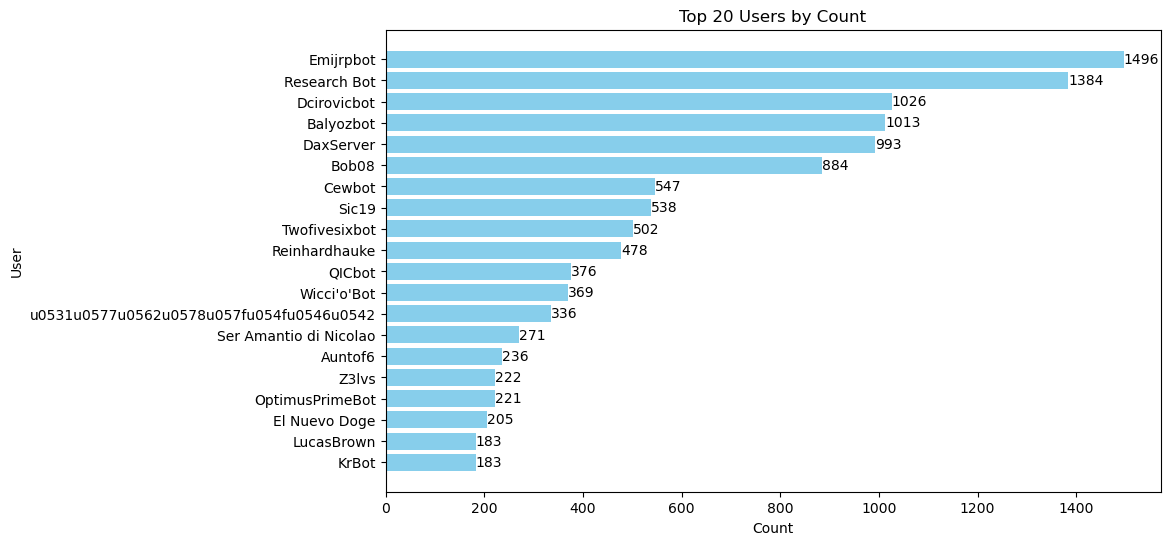

In [9]:
# Retrieve data for the top 20 users
top_20_users = distinct_users_sorted.limit(20).toPandas()

# Draw a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top_20_users['user'], top_20_users['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('User')
plt.title('Top 20 Users by Count')
plt.gca().invert_yaxis()  # Invert the y-axis to display the users with the highest count at the top

# Display values on the bar chart
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), 
             va='center', ha='left', fontsize=10)

plt.show()

In [10]:
# Download the required data for NLTK
nltk.download('punkt')

# Merge all comments into a single string
all_comments = ' '.join(df.select("comment").rdd.flatMap(lambda x: x).collect())

# Tokenize the comments using NLTK
tokens = word_tokenize(all_comments)

# Calculate word frequencies
word_freq = Counter(tokens)

# Replace punctuation with spaces
df_no_punctuation = df.withColumn("comment_no_punct", regexp_replace(df["comment"], "[^\w\s]", " "))

# Split words in comment_no_punct
words = df_no_punctuation.select(explode(split(df_no_punctuation.comment_no_punct, "\s")).alias("word"))

# Filter out empty strings and punctuation
words_filtered = words.filter(words.word != "")

# Calculate word frequencies
word_freq = words_filtered.groupBy("word").count().orderBy("count", ascending=False)

# Convert the result to a Pandas DataFrame
word_freq_pd = word_freq.limit(100).toPandas()

# Print the top 100 most frequent words
print(word_freq_pd)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


         word  count
0           1   7070
1       batch   4446
2    Property   4022
3         add   3888
4        from   3438
..        ...    ...
95         ka    407
96        Add    407
97  Q70923324    405
98       Gift    397
99         ro    394

[100 rows x 2 columns]


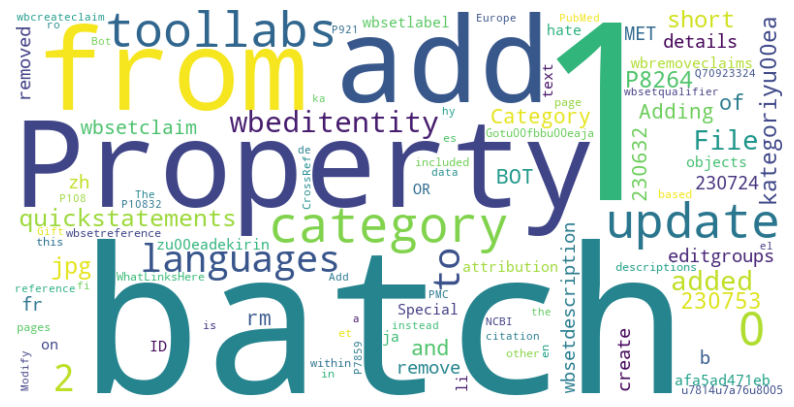

In [11]:
# Convert the result to dictionary format
word_freq_dict = dict(zip(word_freq_pd['word'], word_freq_pd['count']))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [12]:
filtered_df = df.filter(~col("user").rlike("(?i)bot"))

# Analyze the actions of the remaining users
user_actions = filtered_df.groupBy("user").agg({"comment": "count"}).orderBy(col("count(comment)").desc())

# Display the actions of the top 20 users
user_actions.show()

+--------------------+--------------+
|                user|count(comment)|
+--------------------+--------------+
|           DaxServer|           993|
|               Bob08|           884|
|               Sic19|           538|
|       Reinhardhauke|           478|
|u0531u0577u0562u0...|           336|
|Ser Amantio di Ni...|           271|
|             Auntof6|           236|
|               Z3lvs|           222|
|       El Nuevo Doge|           205|
|          LucasBrown|           183|
|u041au0440u0430u0...|           134|
|          Imamanik05|           132|
|      Engineerchange|            96|
|          NeverDoING|            96|
|            Fitindia|            92|
|              Jagwar|            88|
|        Mr.Rosewater|            74|
|         Bodhisattwa|            63|
|     Alachuckthebuck|            63|
|             Xezbeth|            61|
+--------------------+--------------+
only showing top 20 rows



In [13]:
# Download the necessary data for NLTK
nltk.download('punkt')

# Filter comments excluding those from BOT users
filtered_comments = df.filter(~col("user").rlike("(?i)bot"))

# Merge all comments into a single string
all_comments = ' '.join(map(str, filtered_comments.rdd.flatMap(lambda x: x).collect()))

# Tokenize the comments using NLTK
tokens = word_tokenize(all_comments)

# Calculate word frequencies
word_freq = Counter(tokens)

# Replace punctuation with spaces
df_no_punctuation = filtered_comments.withColumn("comment_no_punct", regexp_replace(filtered_comments["comment"], "[^\w\s]", " "))

# Split words in comment_no_punct
words = df_no_punctuation.select(explode(split(df_no_punctuation.comment_no_punct, "\s")).alias("word"))

# Filter out empty strings and punctuation
words_filtered = words.filter(words.word != "")

# Calculate word frequencies
word_freq = words_filtered.groupBy("word").count().orderBy("count", ascending=False)

# Filter out words with count less than 500
word_freq_filtered = word_freq.filter(word_freq["count"] < 500)

# Take the top 100 most frequent words
top_100_words = word_freq_filtered.limit(100).toPandas()

# Print the top 100 most frequent words
print(top_100_words)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


             word  count
0             and    467
1             the    458
2             The    446
3            Gift    397
4       Meersburg    392
..            ...    ...
95         Edward     82
96         Prints     82
97  photographers     80
98         rivers     80
99         Martin     79

[100 rows x 2 columns]


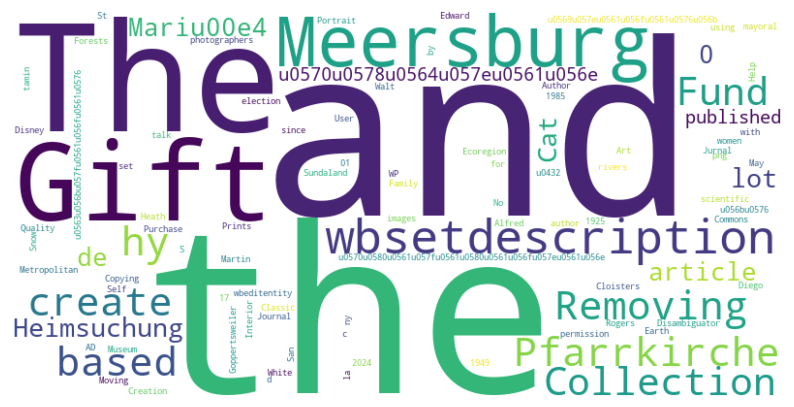

In [14]:
# Convert Pandas DataFrame to dictionary
word_freq_dict = dict(zip(top_100_words["word"], top_100_words["count"]))

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [15]:
# Meersburg 梅爾斯堡
# Pfarrkirche 藍紹教堂(維也納)
# wbsetdescription 維基百科 API
# Fund 基金
# Collection article 收藏史雜誌
# Museum 博物館